## Gaussian pulse moving through dielectric $\varepsilon$ and absorbing $\sigma$ layers

Study the optimal values of PML's for different frequencies and PML widths to minimize reflection:

![](https://codimd.web.cern.ch/uploads/upload_377b25730e2b4ec04c803bbab82562da.gif)

### Simulation with wakis
----

In [7]:
from scipy.constants import c as c_light
import numpy as np
from tqdm import tqdm

from wakis.solverFIT3D import SolverFIT3D
from wakis.gridFIT3D import GridFIT3D
from wakis.sources import WavePacket

# Plotting settings
import pyvista as pv
import matplotlib.animation
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

%matplotlib ipympl
pv.set_jupyter_backend('html') 

### Domain definition and absorbing barriers

In [8]:
# barrier dimensions
lx, ly, lz = 5., 5., 10.

# Domain bounds
xmin, xmax, ymin, ymax, zmin, zmax = -lx/2., lx/2., -ly/2., ly/2., -lz/2.,lz/2.

# Number of mesh cells
Nx = 4
Ny = 4
Nz = 800

# cell size
dx, dy, dz = lx/Nx, ly/Ny, lz/Nz

# Barriers
barrier = {}
stl_solids = {}
stl_materials = {}

n = 16
ss = np.linspace( np.sqrt(1.e-4), np.sqrt(1.e-1), n, )
ss = ss*ss

width = 2.*dz
pos_z_begin = zmax - n*width

for k, si in enumerate(ss):
    
    name = f'b{k}'
    file_name = f'notebooks/data/003_barrier{k}.stl'
    
    barrier[k] = pv.Cube( x_length=lx, y_length=ly, z_length=width, center=(0,0,pos_z_begin+k*width))
    barrier[k].save( file_name, )

    stl_solids[name] = file_name
    stl_materials[name] = [ 1.+si, 1., si, ]

In [9]:
# Simulation grid
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, 
                 Nx, Ny, Nz, 
                 stl_solids=stl_solids, 
                 stl_materials=stl_materials)
for k in grid.stl_colors:
    grid.stl_colors[k] = 'tab:red'
grid.plot_solids(bounding_box=True)

Generating grid...
Importing stl solids...


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

### Solver setup

In [10]:
# boundary conditions
bc_low=['periodic', 'periodic', 'pec']  
bc_high=['periodic', 'periodic', 'pec']

solver = SolverFIT3D(grid=grid,     # pass grid object
                     cfln=0.50,       # Default if no dt is defined
                     bc_low=bc_low, 
                     bc_high=bc_high, 
                     use_stl=True,     # Enables or disables geometry import
                     bg='vacuum',      # Background material 
                     use_gpu=False,
                     )


Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Pre-computing ...
Total initialization time: 0.07219266891479492 s


### Source setup

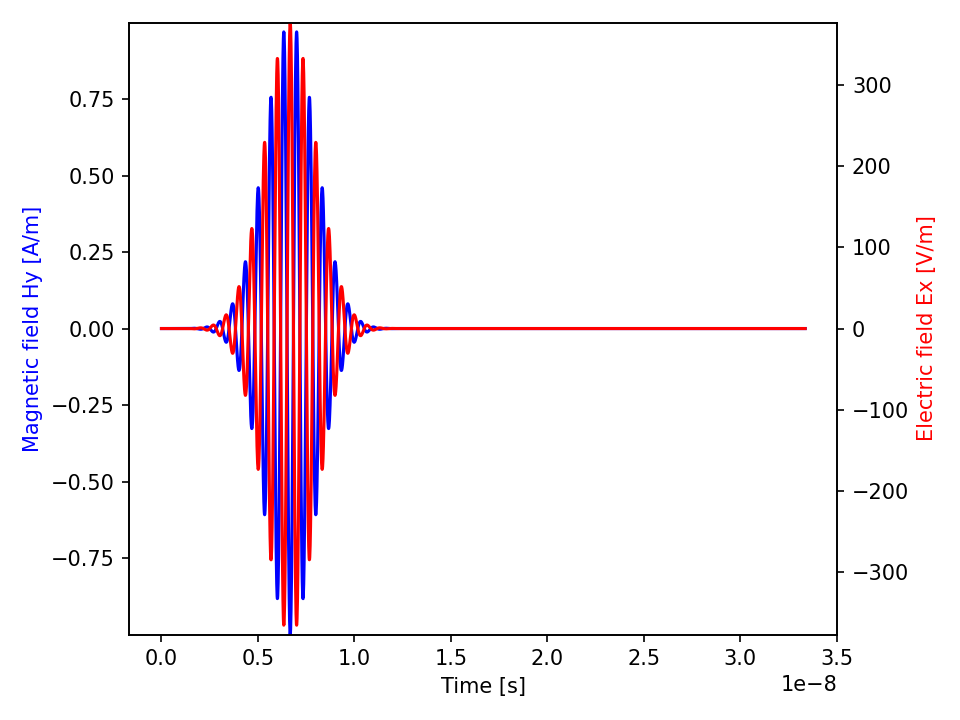

In [11]:
# Add Gaussian wavepacket
source = WavePacket(xs=slice(0,Nx), ys=slice(0,Ny),
                    sigmaxy=100.,
                    sigmaz=.4,
                    wavelength=16.*dz,
                    tinj=2.0,
                    amplitude=1.)

t = np.arange(0,(zmax-zmin)/c_light, solver.dt)

# Plot source in time
source.plot( t, )

# plot 2d
X, Y = np.meshgrid(solver.x, solver.y)
gaussxy = np.exp(-(X**2+Y**2)/(2*source.sigmaxy**2))
#plt.figure()
#plt.contourf(X,Y,gaussxy)

### Time-stepping

In [12]:
#initialize to 0
for d in ['x','y','z']:
    solver.E[:,:,:,d] = 0.
    solver.H[:,:,:,d] = 0.
    solver.J[:,:,:,d] = 0.

# Fields to save
Ex, Ey, Hx, Hy, Jz = [], [], [], [], []

plot2D=False #Turn on to generate 2d plots on-the-fly!

N1 = 5*int((2+zmax-zmin)/c_light/solver.dt)
for n in tqdm(range(N1)):

    #apply source
    source.update(solver, solver.dt*n)

    #Advance fields
    solver.one_step()

    if n%100 == 0:
        Ex.append(solver.E[Nx//2, Ny//2, :, 'x'])
        Ey.append(solver.E[Nx//2, Ny//2, :, 'y'])
        Hx.append(solver.H[Nx//2, Ny//2, :, 'x'])
        Hy.append(solver.H[Nx//2, Ny//2, :, 'y'])
        Jz.append(solver.J[Nx//2, Ny//2, :, 'z'])

    if plot2D and n%100 == 0:
        solver.plot2D(field='H', component='y', plane='ZY', pos=0.5, norm='symlog', 
               vmin=-1, vmax=1, figsize=[8,4], cmap='RdBu', patch_alpha=0.1, 
               add_patch=False, off_screen=True, n=n, interpolation='spline36',
               title='notebooks/data/003_Hy',)

100%|██████████| 19200/19200 [00:19<00:00, 984.54it/s] 


### Plotting and animations 

In [13]:
# quick 3d plotting
solver.plot3D( 'Hy', add_stl='b1', clip_interactive=True, stl_opacity=0.4, cmap='gnuplot' )

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

MovieWriter ffmpeg unavailable; using Pillow instead.


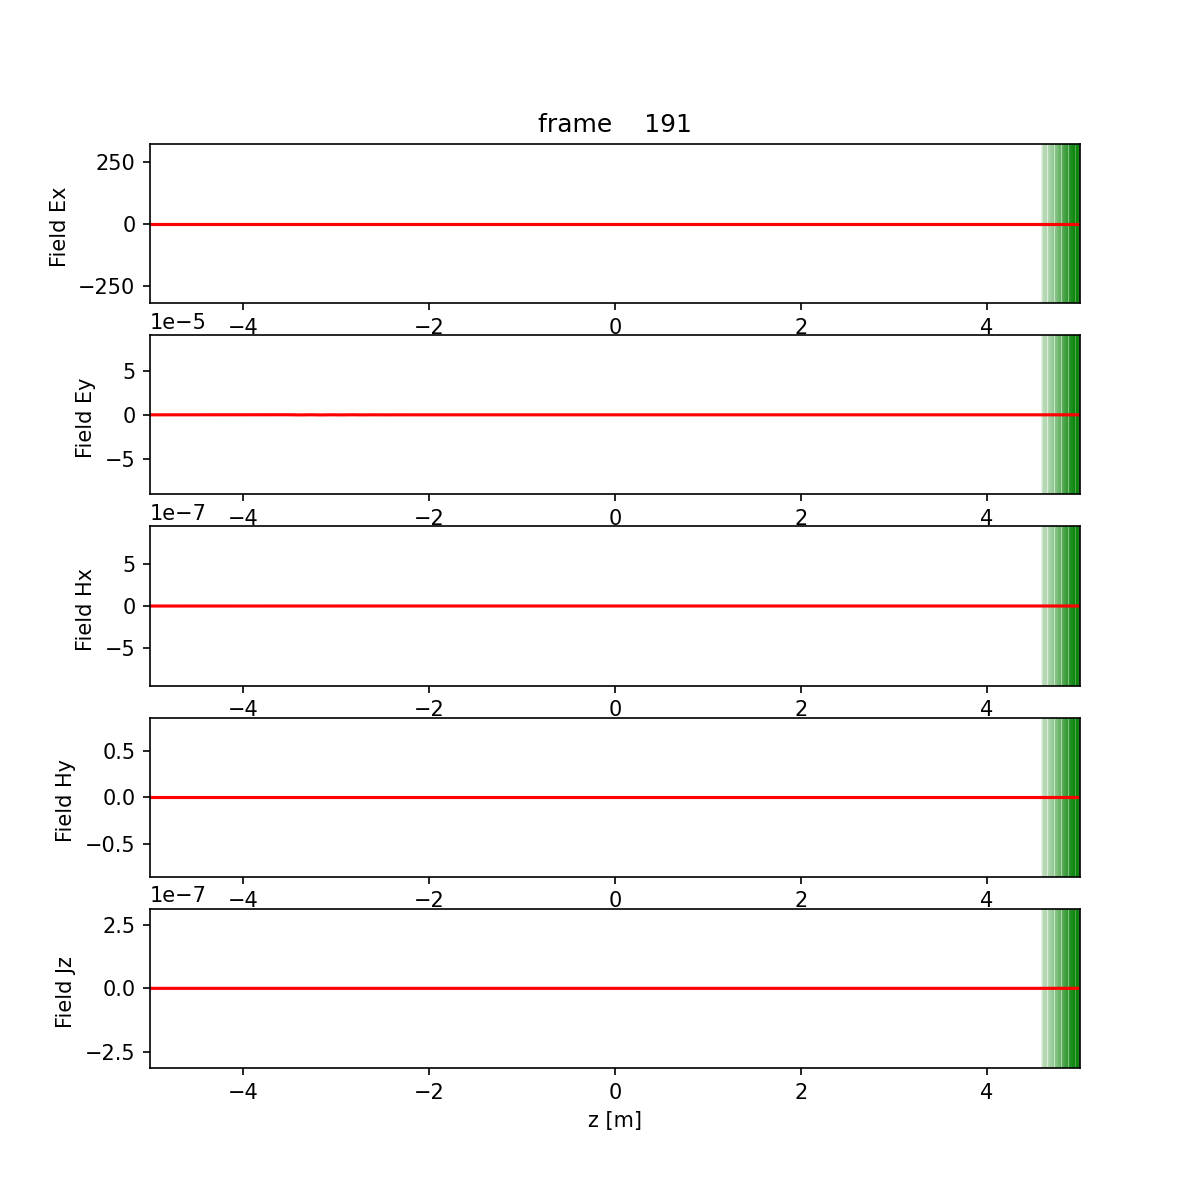

In [14]:
from argparse import Namespace as NS
fields = { 
  'Ex': NS( values=np.array(Ex), units='', ), 
  'Ey': NS( values=np.array(Ey), units='', ), 
  'Hx': NS( values=np.array(Hx), units='', ),
  'Hy': NS( values=np.array(Hy), units='', ),
  'Jz': NS( values=np.array(Jz), units='', ),
}

# frames animation
fig, axs = plt.subplots( len(fields), 1, figsize=[8,8], dpi=150, )

axs[-1].set_xlabel(f'z [m]')
for ax, ( ki, vi, ) in zip(axs,fields.items()):

  ax.set_ylabel(f'Field {ki} {vi.units}')

  q = np.abs(vi.values).max()
  ax.set_ylim((-q,q))
  ax.set_xlim((zmin,zmax))
  
  # barriers
  for b, si in zip(barrier.values(),ss):
    xlo, xhi, ylo, yhi, zlo, zhi = b.bounds
    ax.axvspan(zlo, zhi, color='g', alpha=.1 + .6*si/ss.max())

  ls = [ ax.plot(solver.z, np.full_like( solver.z, np.nan, ), c='r')[0] for ax in axs ]

def animate(frame,ls,fields,axs):
  fig.gca()
  axs[0].set_title(f'frame {frame:6d}')
  # field
  for li, ( ki, vi, ) in zip(ls,fields.items()):
    li.set( data=(solver.z,vi.values[frame]), )
  return ls

anim = matplotlib.animation.FuncAnimation(fig, lambda frame: animate(frame,ls,fields,axs), frames=len(vi.values), )
anim.save(f'notebooks/data/003_movie.gif')

### Metrics to analyise absortion

In [15]:
def metric_area( f, ):
    return np.sum(np.abs(f))

def metric_length( f, ):
    df = np.diff(f)
    return np.sum(np.sqrt(1. + df*df))/len(df) - 1

for vi in fields.values():
    vi.area = np.array([ metric_area(fs) for fs in vi.values ])
    vi.area /= vi.area.max()
    vi.length = np.array([ metric_length(fs) for fs in vi.values ])
    vi.length /= vi.length.max()

/tmp/ipykernel_24429/3585792959.py:12: RuntimeWarning: invalid value encountered in divide
  vi.length /= vi.length.max()


(<matplotlib.legend.Legend at 0x5fa70bf8b7d0>,
 <matplotlib.legend.Legend at 0x5fa70be9dc10>)

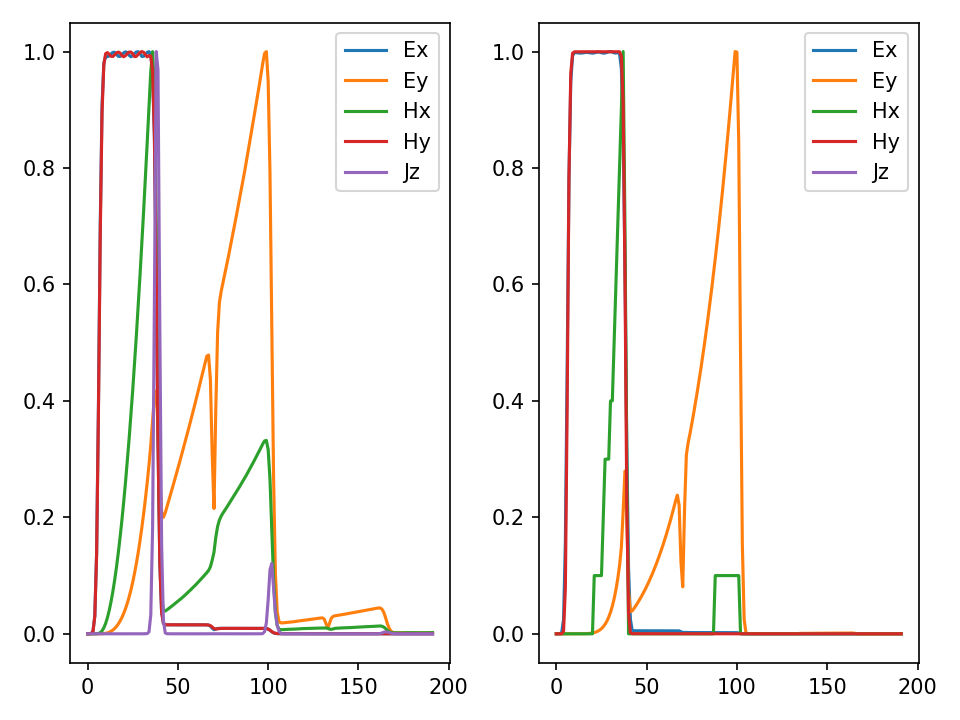

In [16]:
fig, ( ax1, ax2, ) = plt.subplots( 1, 2, tight_layout=True, )

for ki, vi in fields.items():
    ax1.plot( vi.area, label=ki, )
    ax2.plot( vi.length, label=ki, )

ax1.legend(), ax2.legend()